# Synthèse

In [1]:
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)


import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import sys
sys.path.append("../scripts/")

# librairies perso
from import_data import import_data
from metrics import metrics, tab_mesure 
from group_by_clients import group_by_clients
from creation_model import complet_process
from display import display_mesure, display_prediction
from metrics import export_mesure, permutation_feature_importance
from model_objet import Model

In [2]:
data = import_data()

def set_up_index(index): 
    index.rename({"Date": "horodate"}, axis = 1, inplace = True)
    index["horodate"] = pd.to_datetime(index["horodate"])
    index.set_index("horodate", inplace = True)
    index = index.asfreq("D")
    index.reset_index(inplace = True)
    index = index.fillna(method = "ffill")
    date = (index["horodate"] >= pd.to_datetime("2021-01-01")) & (index["horodate"] <= pd.to_datetime("2023-01-31"))
    index = index[date]
    index.reset_index(inplace = True)
    index = index[["horodate", "Open"]]
    return index 

CAC = pd.read_csv("../data/^FCHI.csv")
AEX = pd.read_csv("../data/^AEX.csv")
BFX = pd.read_csv("../data/^BFX.csv")
STOXX = pd.read_csv("../data/^STOXX50E.csv")
Airliquide = pd.read_csv("../data/AI.PA.csv")
gasNat = pd.read_csv("../data/gasNat.csv").rename({"Ouvert": "Open"}, axis = 1)

CAC = set_up_index(CAC)
AEX = set_up_index(AEX)
BFX = set_up_index(BFX)
STOXX = set_up_index(STOXX)
Airliquide = set_up_index(Airliquide)
gasNat = set_up_index(gasNat)

CAC.rename({"Open": "CAC"}, axis = 1, inplace = True)
AEX.rename({"Open": "AEX"}, axis = 1, inplace = True)
BFX.rename({"Open": "BFX"}, axis = 1, inplace = True)
STOXX.rename({"Open": "STOXX"}, axis = 1, inplace = True)
Airliquide.rename({"Open": "Airliquide"}, axis = 1, inplace = True)
gasNat.rename({"Open": "gasNat"}, axis = 1, inplace = True)

#CAC.rename({"Volume": "CAC"}, axis = 1, inplace = True)
#AEX.rename({"Volume": "AEX"}, axis = 1, inplace = True)
#BFX.rename({"Volume": "BFX"}, axis = 1, inplace = True)
#STOXX.rename({"Volume": "STOXX"}, axis = 1, inplace = True)

# il faut merge avec le tableau principal
data = pd.merge(data, CAC, on = ["horodate"], how = "left")
data = pd.merge(data, AEX, on = ["horodate"], how = "left")
data = pd.merge(data, BFX, on = ["horodate"], how = "left")
data = pd.merge(data, STOXX, on = ["horodate"], how = "left")
data = pd.merge(data, Airliquide, on = ["horodate"], how = "left")
data = pd.merge(data, gasNat, on = ["horodate"], how = "left")
n = data["id_client"].max()
test_data = data[data["horodate"] > pd.to_datetime("2022-08-31")]

data = data[~(data["id_client"].isin([8,9, 17, 23, 28, 37, 38 , 49]))]

In [3]:
data

,id_client,horodate,real_consumption,forecasted_consumption,prediction,CAC,AEX,BFX,STOXX,Airliquide,gasNat
0,1,2021-01-01,8396.00,8400.0,8323.319457,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
1,1,2021-01-02,8395.00,8400.0,8194.785384,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
2,1,2021-01-03,8396.00,8400.0,8183.265980,5573.200195,625.190002,3641.530029,3580.909912,122.727272,2.433
3,1,2021-01-04,8397.00,8400.0,8420.826672,5614.040039,632.020020,3671.080078,3565.679932,123.590912,2.626
4,1,2021-01-05,8395.73,8400.0,8123.422185,5561.600098,629.940002,3645.760010,3554.239990,123.136360,2.599
...,...,...,...,...,...,...,...,...,...,...,...
36522,48,2023-01-27,0.00,0.0,6884.857307,7085.470215,749.309998,3868.540039,4177.259766,147.919998,2.876
36523,48,2023-01-28,0.00,0.0,6823.391661,7085.470215,749.309998,3868.540039,4177.259766,147.919998,2.876
36524,48,2023-01-29,0.00,0.0,6718.316456,7085.470215,749.309998,3868.540039,4177.259766,147.919998,2.876
36525,48,2023-01-30,0.00,0.0,6862.322000,7054.240234,743.090027,3848.070068,4166.750000,147.899994,2.720


# Analyse des corrélations

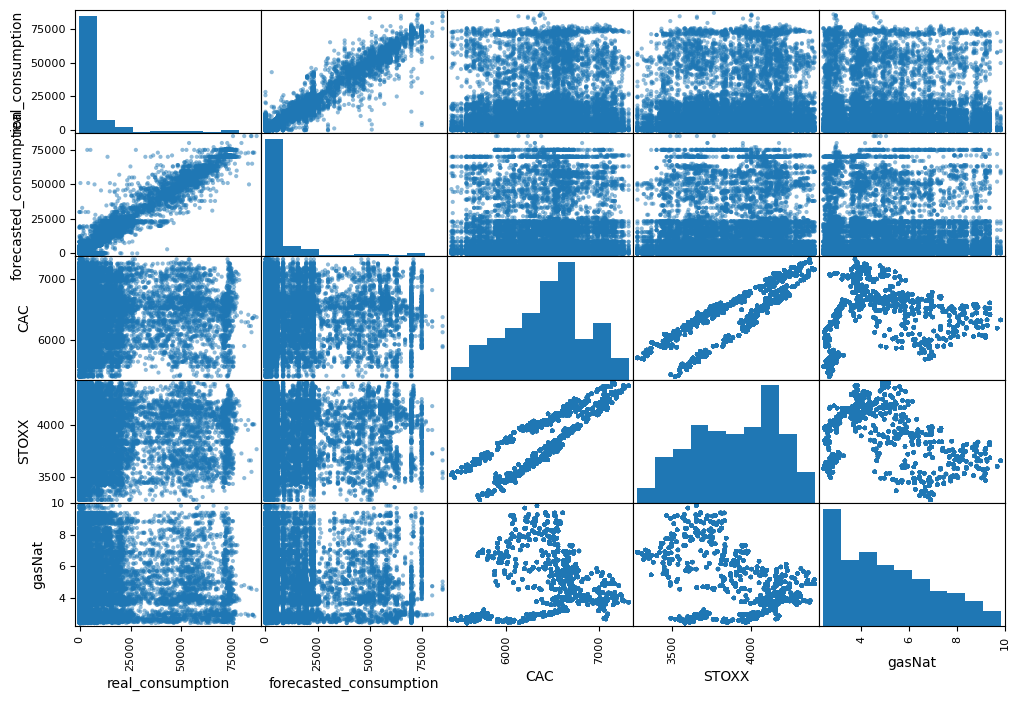

In [ ]:
attributes = ["real_consumption","forecasted_consumption", "CAC", "STOXX", "gasNat"]
axes = pd.plotting.scatter_matrix(data[attributes], figsize=(12, 8))
"""
# Masquer les sous-parcelles sauf la première ligne
for i, row in enumerate(axes):
    if i == 0 : 
        for j, subplot in enumerate(row) : 
            subplot.set_xlabel(attributes[j])
    else :
        for subplot in row : 
            subplot.set_visible(False)
"""
# Afficher la matrice de dispersion
plt.show()

## Régression linéaire

### Ajustement de la date butoir

In [5]:
# En groupant par client
best_mse = [0,np.inf]
best_mae = [0, np.inf]
best_moy = [0, np.inf]
for i in range(1,90): 
    model, eval_model = complet_process(data, ["forecasted_consumption", "gasNat"], ["real_consumption"],i/100, group = True, random_forest = False , n_estimators = 150)
    if tab_mesure(eval_model).describe().loc["mean", "MSE"] < best_mse[1] : 
        best_mse[0], best_mse[1] = i/100, tab_mesure(eval_model).describe().loc["mean", "MSE"]
    if tab_mesure(eval_model).describe().loc["mean", "MAE"] < best_mae[1] : 
        best_mae[0], best_mae[1] = i/100, tab_mesure(eval_model).describe().loc["mean", "MAE"]
    if (tab_mesure(eval_model).describe().loc["mean", "MAE"] + tab_mesure(eval_model).describe().loc["mean", "MSE"])/2 < best_moy[1] : 
        best_moy[0], best_moy[1] = i/100, (tab_mesure(eval_model).describe().loc["mean", "MAE"] + tab_mesure(eval_model).describe().loc["mean", "MSE"])/2
best_mse[0], best_mae[0], best_moy[0]

(0.71, 0.73, 0.71)

In [6]:
# En ne groupant pas par client
best_mse = [0,np.inf]
best_mae = [0, np.inf]
best_moy = [0, np.inf]
for i in range(1,90): 
    model, eval_model = complet_process(data, ["id_client", "forecasted_consumption", "gasNat"], ["real_consumption"],i/100, group = False, random_forest = False , n_estimators = 150)
    if tab_mesure(eval_model).describe().loc["mean", "MSE"] < best_mse[1] : 
        best_mse[0], best_mse[1] = i/100, tab_mesure(eval_model).describe().loc["mean", "MSE"]
    if tab_mesure(eval_model).describe().loc["mean", "MAE"] < best_mae[1] : 
        best_mae[0], best_mae[1] = i/100, tab_mesure(eval_model).describe().loc["mean", "MAE"]
    if (tab_mesure(eval_model).describe().loc["mean", "MAE"] + tab_mesure(eval_model).describe().loc["mean", "MSE"])/2 < best_moy[1] : 
        best_moy[0], best_moy[1] = i/100, (tab_mesure(eval_model).describe().loc["mean", "MAE"] + tab_mesure(eval_model).describe().loc["mean", "MSE"])/2
best_mse[0], best_mae[0], best_moy[0]

(0.66, 0.85, 0.66)

In [7]:
#Comparaison des méthodes optimales
model1, eval_model1 = complet_process(data, ["id_client", "forecasted_consumption"], ["real_consumption"],0.66, group = False, random_forest = False , n_estimators = 150)
model2, eval_model2 = complet_process(data, ["forecasted_consumption"], ["real_consumption"],0.66, group = True, random_forest = False , n_estimators = 150)

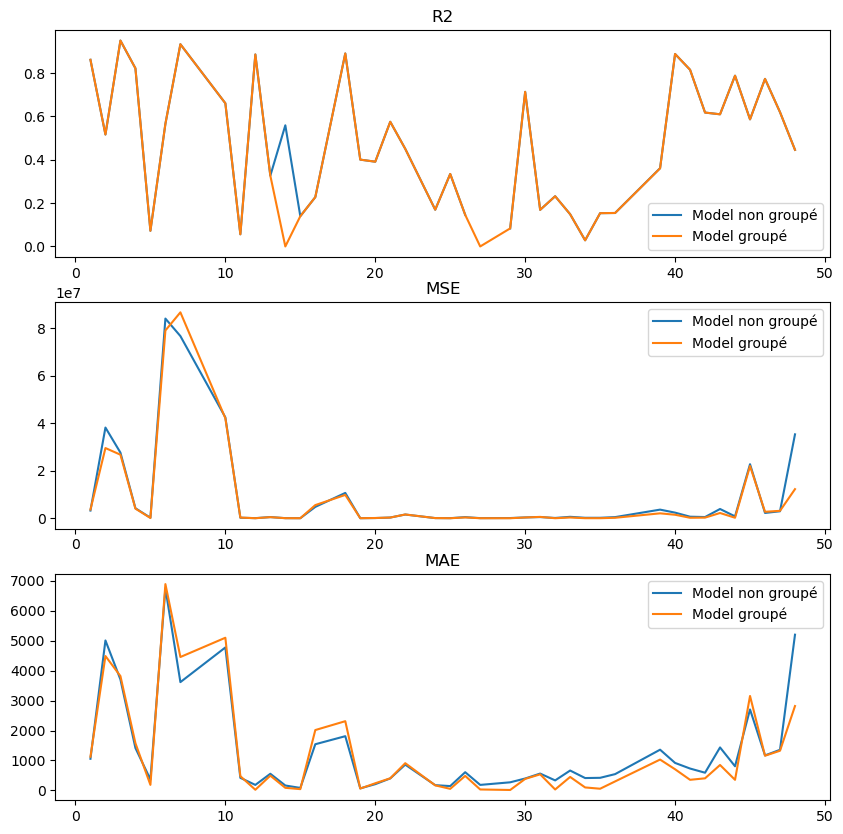

In [8]:
display_mesure(data, [eval_model1, eval_model2], ["Model non groupé", "Model groupé"]);

### Ajout de données supplémentaires

In [9]:
#Model1 (brut): 
model1, eval_model1 = complet_process(data, ["id_client", "forecasted_consumption"], ["real_consumption"],0.66, group = False, random_forest = False , n_estimators = 150)

#Model2 (avec CAC)
model2, eval_model2 = complet_process(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"],0.66, group = False, random_forest = False , n_estimators = 150)

#Model3 (avec CAC, STOXX, AEX, BFX)
model3, eval_model3 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "AEX", "BFX"], ["real_consumption"], 0.72, group = False, random_forest = False , n_estimators = 150)

#Model4 (avec CAC, STOXX, AEX, BFX, airliquide) 
model4, eval_model4 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "AEX", "BFX", "Airliquide"], ["real_consumption"], 0.72, group = False, random_forest = False , n_estimators = 150)

#Model5 (avec CAC, gasNat) 
model5, eval_model5 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "gasNat"], ["real_consumption"], 0.66, group = False, random_forest = False , n_estimators = 150)

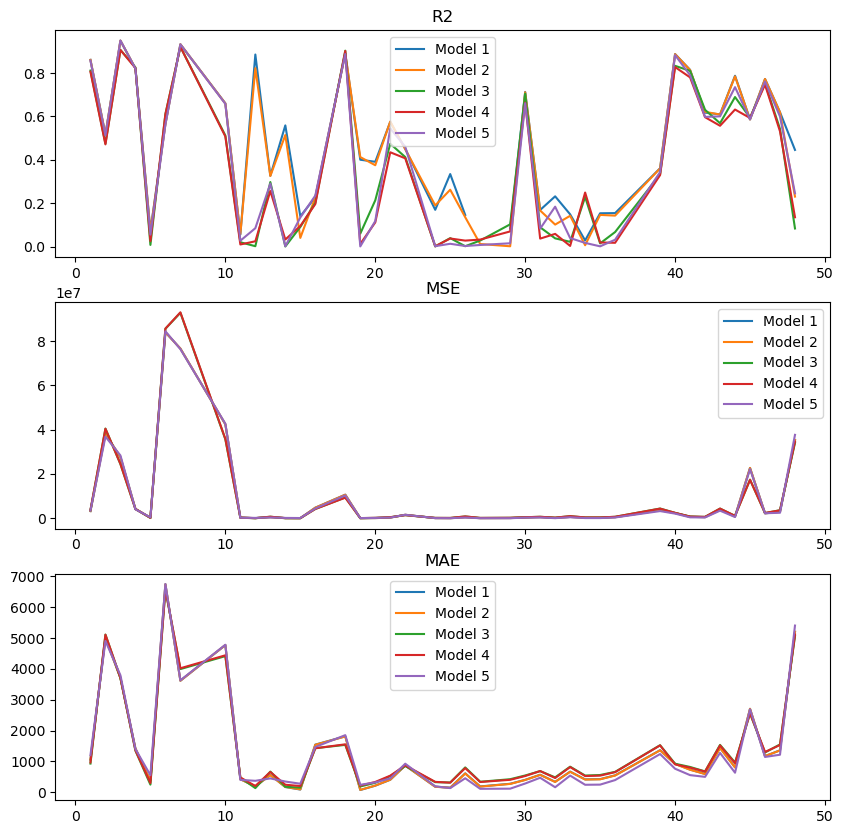

In [10]:
display_mesure(data, [eval_model1, eval_model2, eval_model3, eval_model4, eval_model5], [f"Model {i}" for i in range(1,6)]);

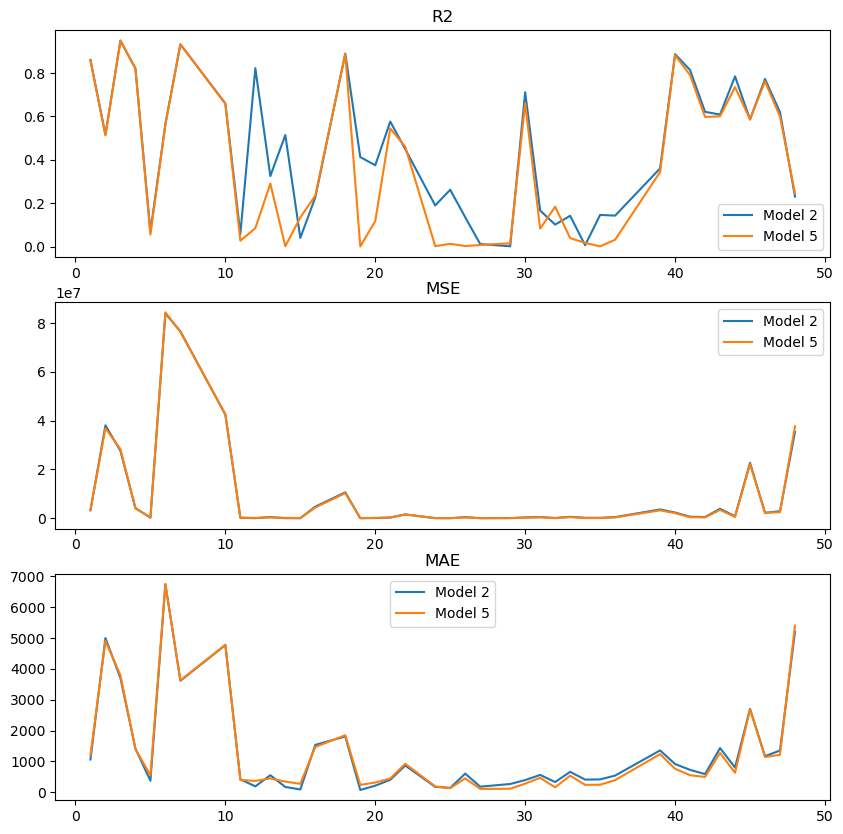

In [11]:
display_mesure(data, [eval_model2, eval_model5], [f"Model 2", "Model 5"]);

La proportion du set de train à privilégier semble être 66%. Les données rajoutées semblent avoir un intérêt mineur. 

## Random Forest Regressor

In [12]:
#Model1 (brut): 
model1, eval_model1 = complet_process(data, ["id_client", "forecasted_consumption"], ["real_consumption"],0.66, group = False, random_forest = True , n_estimators = 150)

#Model2 (avec CAC)
model2, eval_model2 = complet_process(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"],0.66, group = False, random_forest = True , n_estimators = 150)

#Model3 (avec CAC, STOXX, AEX, BFX)
model3, eval_model3 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "AEX", "BFX"], ["real_consumption"], 0.72, group = True, random_forest = False , n_estimators = 150)

#Model4 (avec CAC, STOXX, AEX, BFX, airliquide) 
model4, eval_model4 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "AEX", "BFX", "Airliquide"], ["real_consumption"], 0.72, group = True, random_forest = False , n_estimators = 150)

#Model5 (avec CAC, gasNat) 
model5, eval_model5 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "gasNat"], ["real_consumption"], 0.66, group = False, random_forest = True , n_estimators = 150)

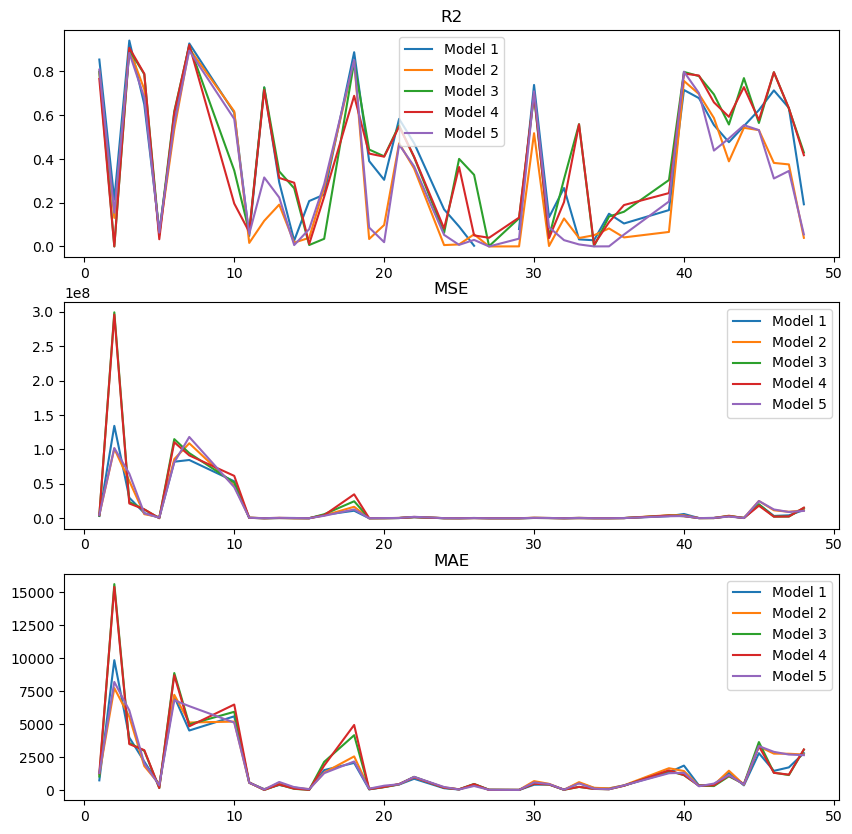

In [13]:
display_mesure(data, [eval_model1, eval_model2, eval_model3, eval_model4, eval_model5], [f"Model {i}" for i in range(1,6)]);

### Comparaison régression linéaire et random forest

In [14]:
#régression linéaire
model_rl, eval_model_rl = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "gasNat"], ["real_consumption"], 0.66, group = False, random_forest = False , n_estimators = 150)
#random forest
model_rf, eval_model_rf = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "gasNat"], ["real_consumption"], 0.66, group = False, random_forest = True , n_estimators = 150)

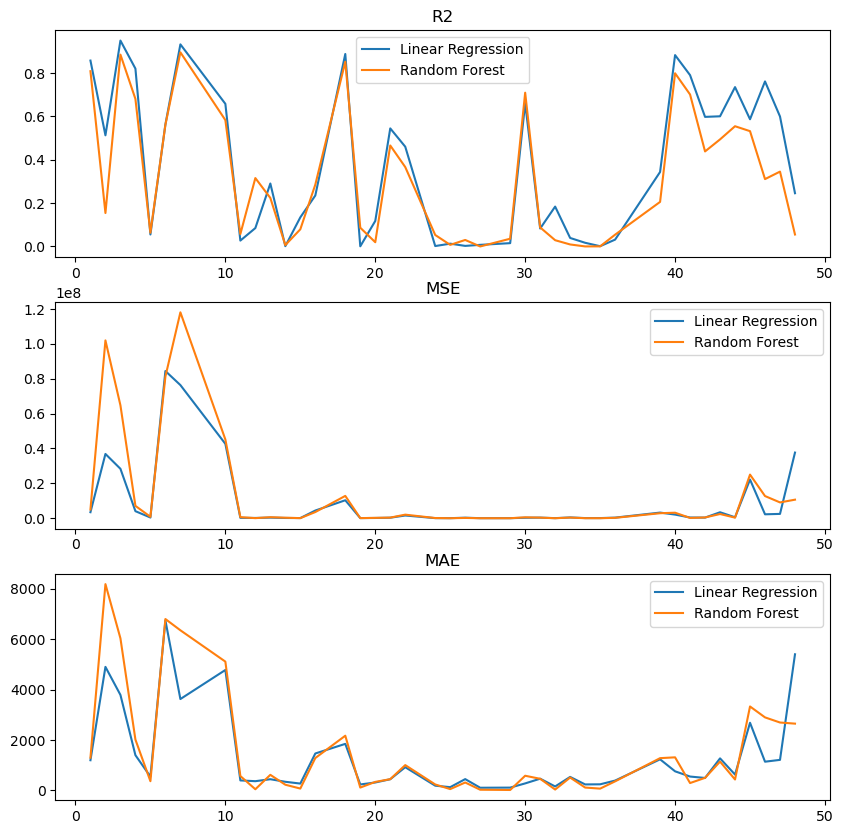

In [15]:
display_mesure(data, [eval_model_rl, eval_model_rf], ["Linear Regression", "Random Forest"]);

In [16]:
#Linear Regression
tab_mesure(eval_model_rl).describe()

,R2,MSE,MAE
count,41.000000,4.100000e+01,41.000000
mean,0.373910,9.044937e+06,1287.243245
std,0.336924,1.980365e+07,1645.745016
min,0.000690,1.863932e+04,107.659068
25%,0.031596,1.442962e+05,316.072458
50%,0.290381,4.020702e+05,537.050122
75%,0.657792,3.449523e+06,1273.599189
max,0.949652,8.441284e+07,6750.726732


In [17]:
#Random Forest
tab_mesure(eval_model_rf).describe()

,R2,MSE,MAE
count,41.000000,4.100000e+01,41.000000
mean,0.313155,1.251715e+07,1523.300875
std,0.301056,2.828922e+07,2097.025798
min,0.000034,6.309237e+02,18.464988
25%,0.052929,1.653591e+05,237.752622
50%,0.223840,5.187161e+05,512.243658
75%,0.554561,7.084436e+06,2018.531781
max,0.895442,1.180746e+08,8191.845643


### Evaluation des features importances

In [18]:
feature_importances = model_rf.feature_importances_
feature_names = ["id_client", "forecasted_consumption", "CAC", "gasNat"]  # Noms des caractéristiques
feature_importances_dict = dict(zip(feature_names, feature_importances))
sorted_importances = sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")


forecasted_consumption: 0.9729077846353383
CAC: 0.010142922716994743
gasNat: 0.00943319895959471
id_client: 0.007516093688072288


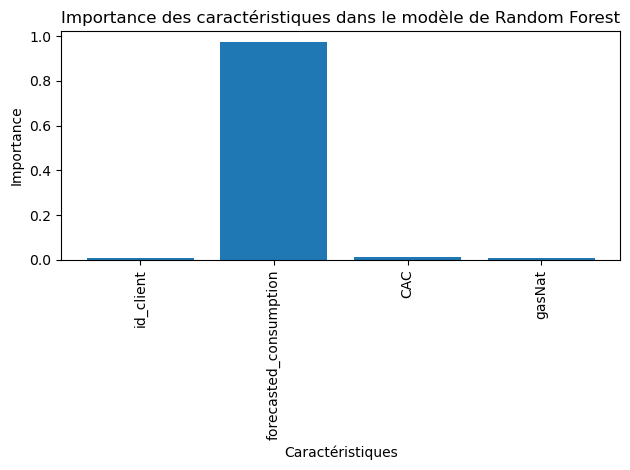

In [19]:
plt.bar(range(len(feature_importances)), feature_importances, align='center')
plt.xticks(range(len(feature_importances)), feature_names, rotation=90)
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.title('Importance des caractéristiques dans le modèle de Random Forest')
plt.tight_layout()

### Permutation feature importance

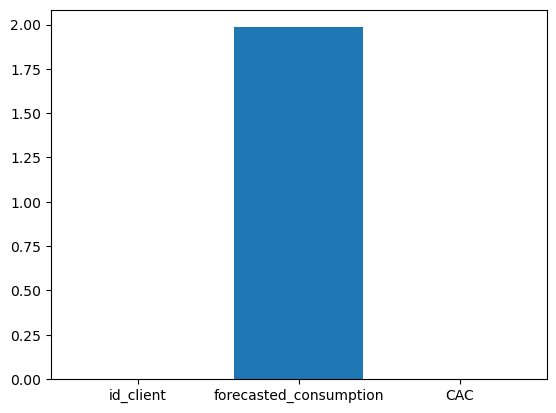

In [20]:
plt.bar(["id_client","forecasted_consumption", "CAC"], permutation_feature_importance(data, ["id_client", "forecasted_consumption", "CAC"],["real_consumption"], 0.66));

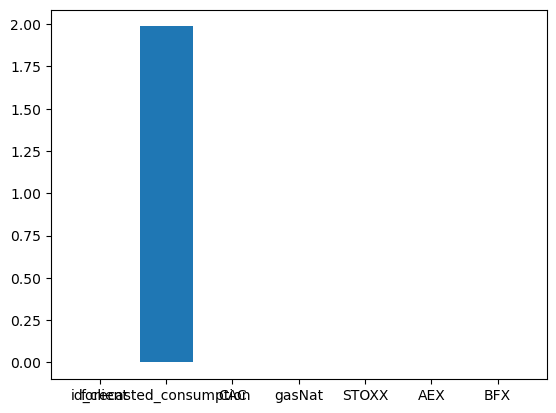

In [21]:
plt.bar(["id_client", "forecasted_consumption", "CAC", "gasNat", "STOXX", "AEX", "BFX"], permutation_feature_importance(data, ["id_client", "forecasted_consumption", "CAC", "gasNat", "STOXX", "AEX", "BFX"],["real_consumption"], 0.66));

## Prendre en compte les dates

In [22]:
data["day"] = data['horodate'].dt.day
data["month"] = data["horodate"].dt.month
data["day_cos"] = np.cos(data["day"])
data["day_sin"] = np.sin(data["day"])
data["month_cos"] = np.cos(data["month"])
data["month_sin"] = np.sin(data["month"])

In [23]:
#Model 1 (sans les dates)
model1, eval_model1 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "gasNat"], ["real_consumption"], 0.66, group = False, random_forest = False , n_estimators = 150)

#Model 2 (avec les dates)
model2, eval_model2 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "gasNat", "day", "day_sin", "day_cos", "month", "month_cos", "month_sin"], ["real_consumption"], 0.66, group = False, random_forest = False , n_estimators = 150)

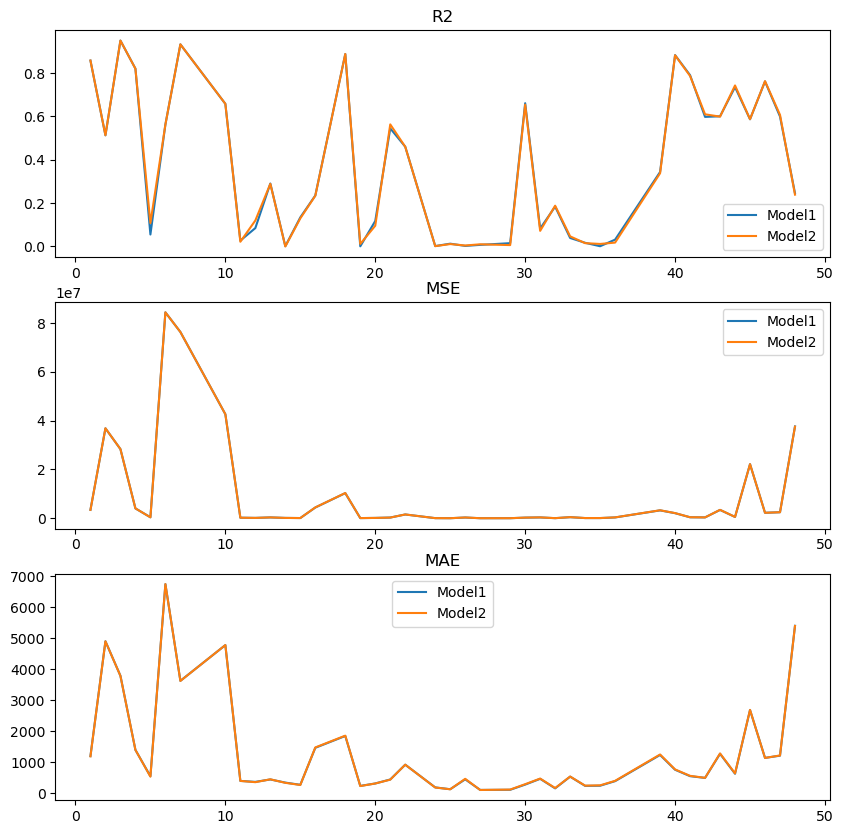

In [24]:
display_mesure(data, [eval_model1, eval_model2], ["Model1", "Model2"]);

On obtient presque les mêmes résulats. 

# Prédire l'erreur plutôt que la valeur réelle 

In [25]:
data["error"] = data["real_consumption"] - data["forecasted_consumption"]

In [26]:
model1, eval_model1 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "gasNat"], ["error"], 0.66, group = False, random_forest = False , n_estimators = 150)
model2, eval_model2 = complet_process(data, ["id_client", "forecasted_consumption", "CAC", "gasNat"], ["real_consumption"], 0.66, group = False, random_forest = False , n_estimators = 150)

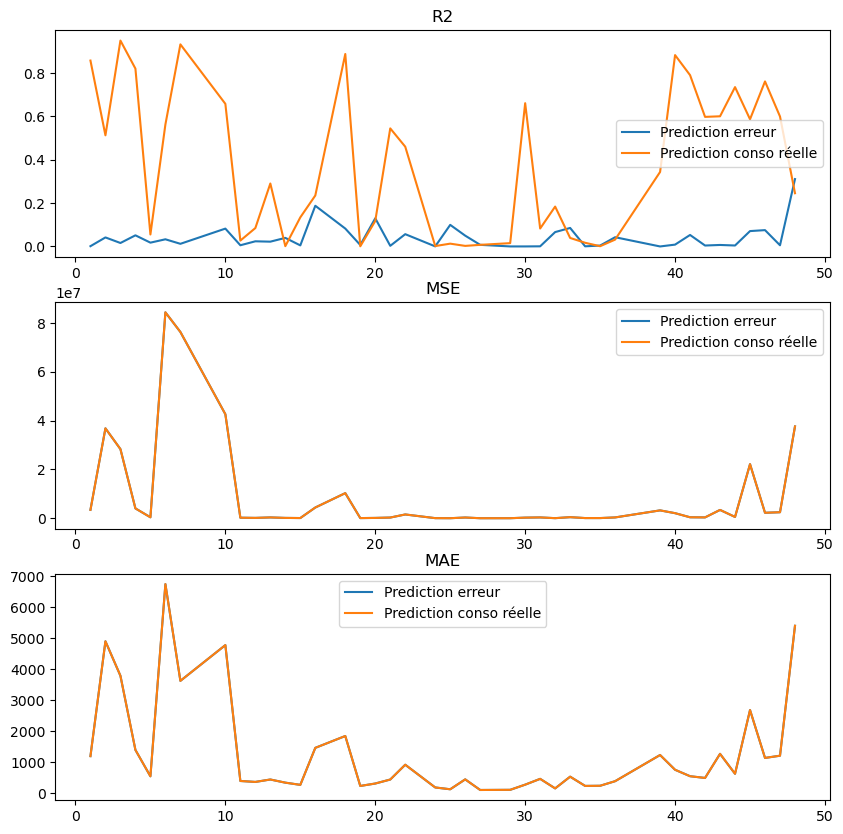

In [27]:
display_mesure(data, [eval_model1, eval_model2], ["Prediction erreur", "Prediction conso réelle"]);

## Gradient Boosting

In [28]:
Model1 = Model(data, ["forecasted_consumption"],["real_consumption"], 0.8, True, "Linear")
Model2 = Model(data, ["forecasted_consumption", "CAC"],["real_consumption"], 0.8, True, "Linear")
Model3 = Model(data, ["forecasted_consumption", "CAC"],["real_consumption"], 0.8, True, "random_forest")
Model4 = Model(data, ["forecasted_consumption", "CAC"],["real_consumption"], 0.8, True, "gradient_boosting")

In [29]:
Model1.complet_process(False)
Model2.complet_process(False)
Model3.complet_process(False)
Model4.complet_process(False)

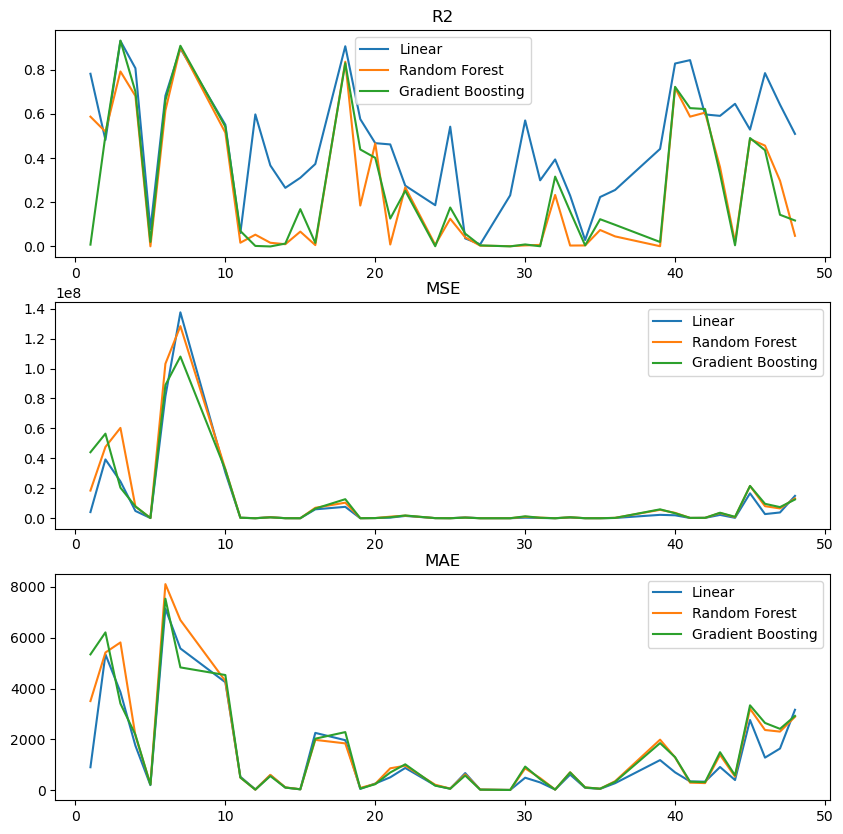

In [30]:
display_mesure(data, [Model2.evaluation_model, Model3.evaluation_model, Model4.evaluation_model], ["Linear", "Random Forest", "Gradient Boosting"]);

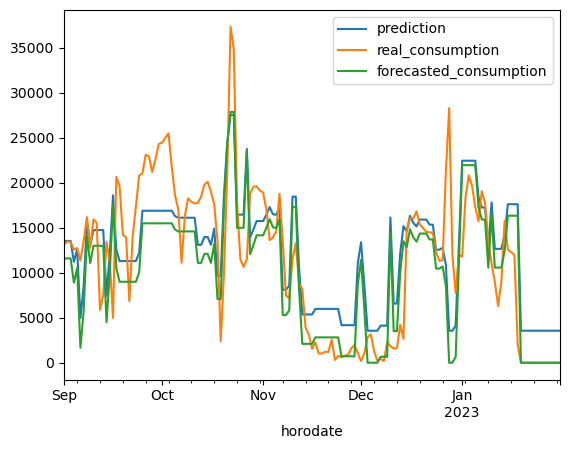

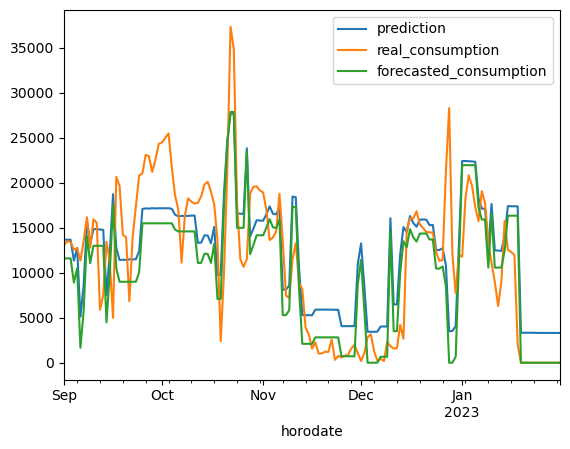

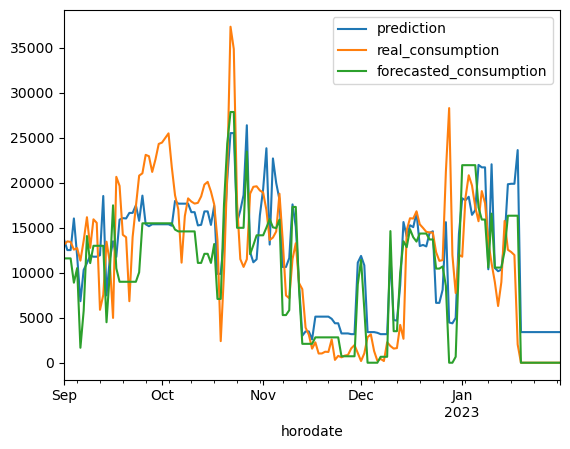

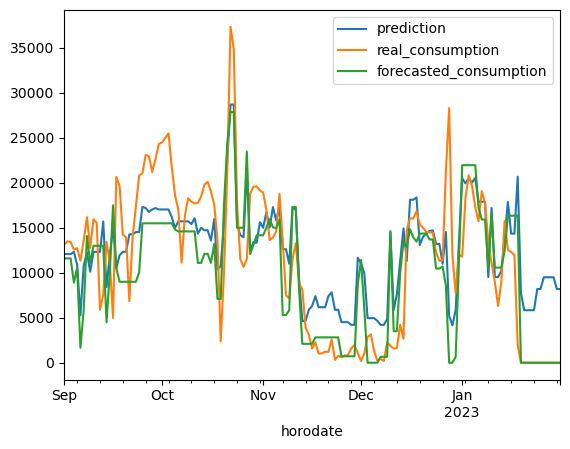

In [31]:
display_prediction(Model1, 7)
display_prediction(Model2, 7)
display_prediction(Model3, 7)
display_prediction(Model4, 7)

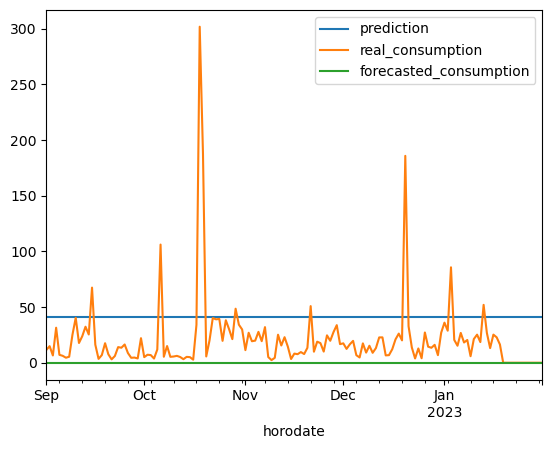

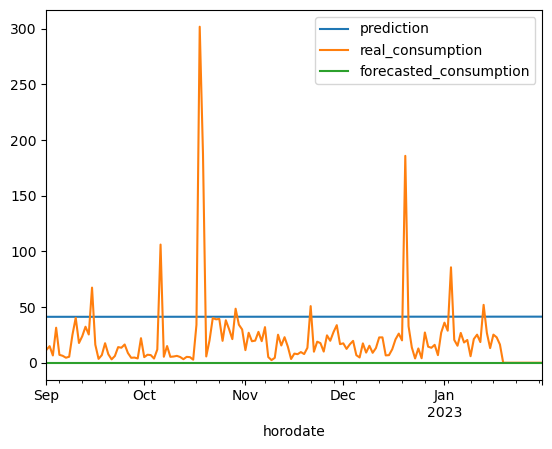

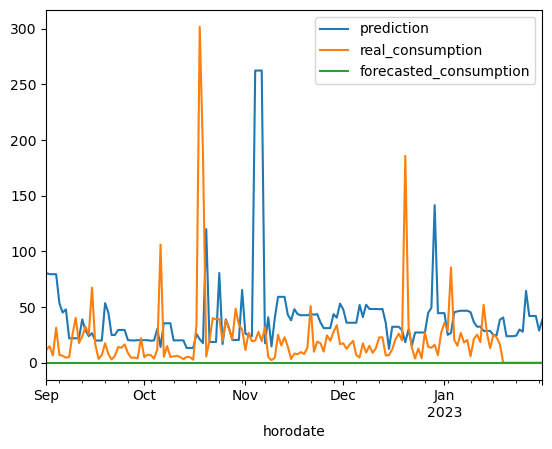

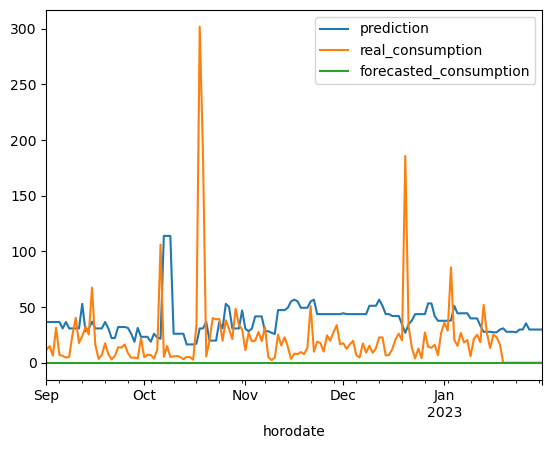

In [32]:
display_prediction(Model1, 22)
display_prediction(Model2, 22)
display_prediction(Model3, 22)
display_prediction(Model4, 22)

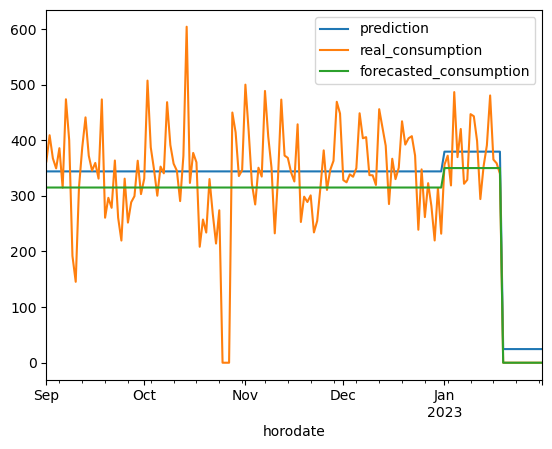

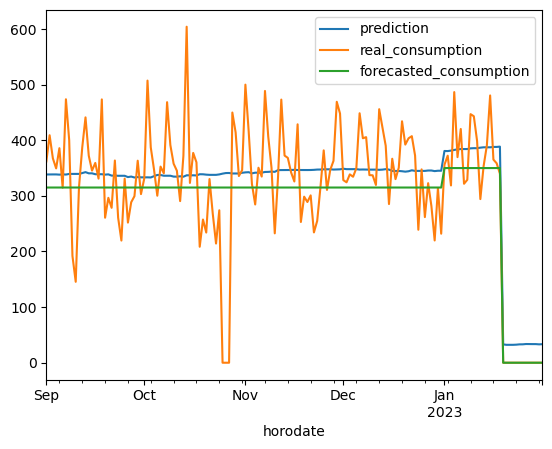

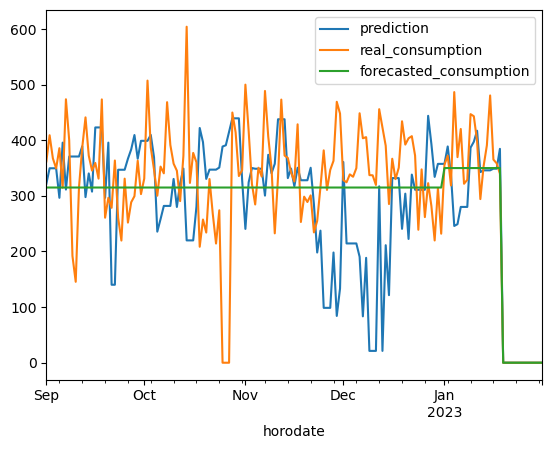

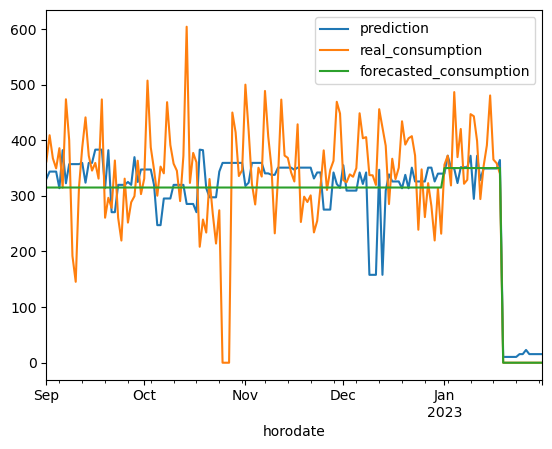

In [33]:
display_prediction(Model1, 15)
display_prediction(Model2, 15)
display_prediction(Model3, 15)
display_prediction(Model4, 15)

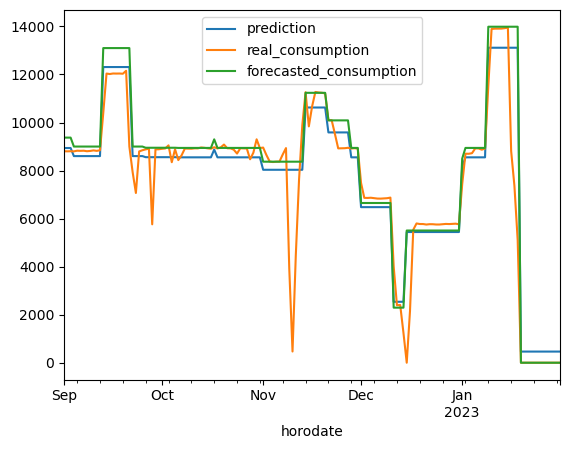

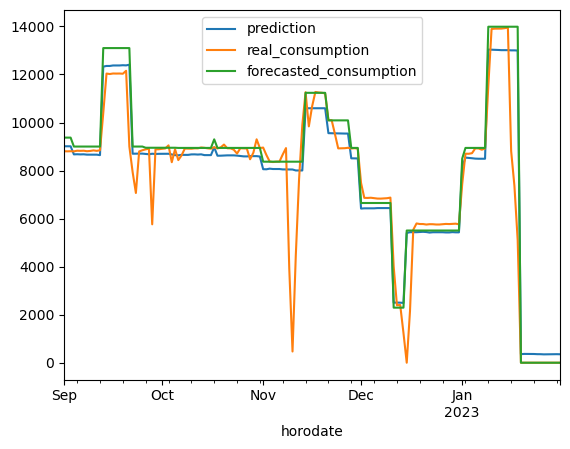

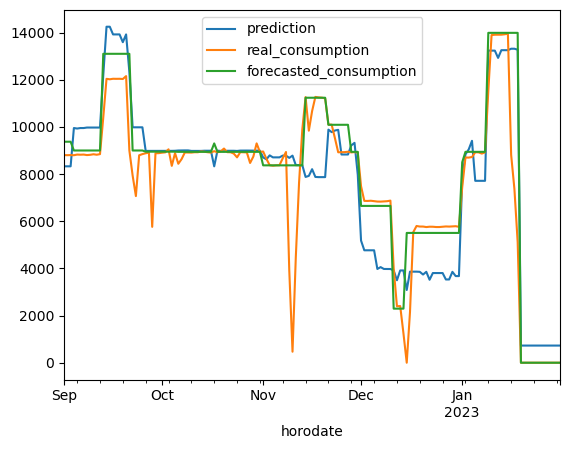

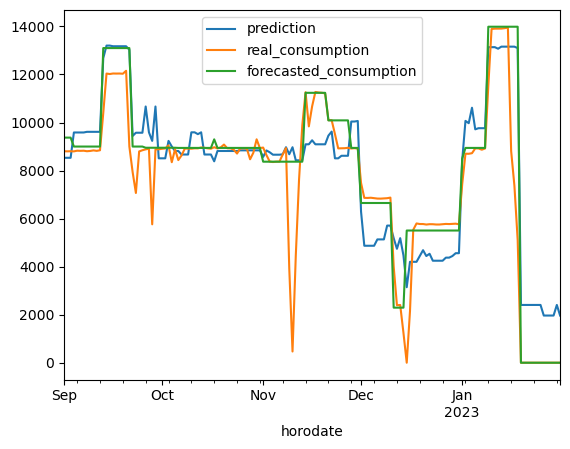

In [34]:
display_prediction(Model1, 32)
display_prediction(Model2, 32)
display_prediction(Model3, 32)
display_prediction(Model4, 32)

## Problème des pics

In [35]:
data2 = data[(data["id_client"] != 7) & (data["id_client"] != 6)]
Model1 = Model(data2, ["forecasted_consumption"],["real_consumption"], 0.8, True, "Linear")
Model2 = Model(data2, ["forecasted_consumption", "CAC"],["real_consumption"], 0.8, True, "Linear")
Model3 = Model(data2, ["forecasted_consumption", "CAC"],["real_consumption"], 0.8, True, "random_forest")
Model4 = Model(data2, ["forecasted_consumption", "CAC"],["real_consumption"], 0.8, True, "gradient_boosting")

In [36]:
Model1.complet_process(False)
Model2.complet_process(False)
Model3.complet_process(False)
Model4.complet_process(False)

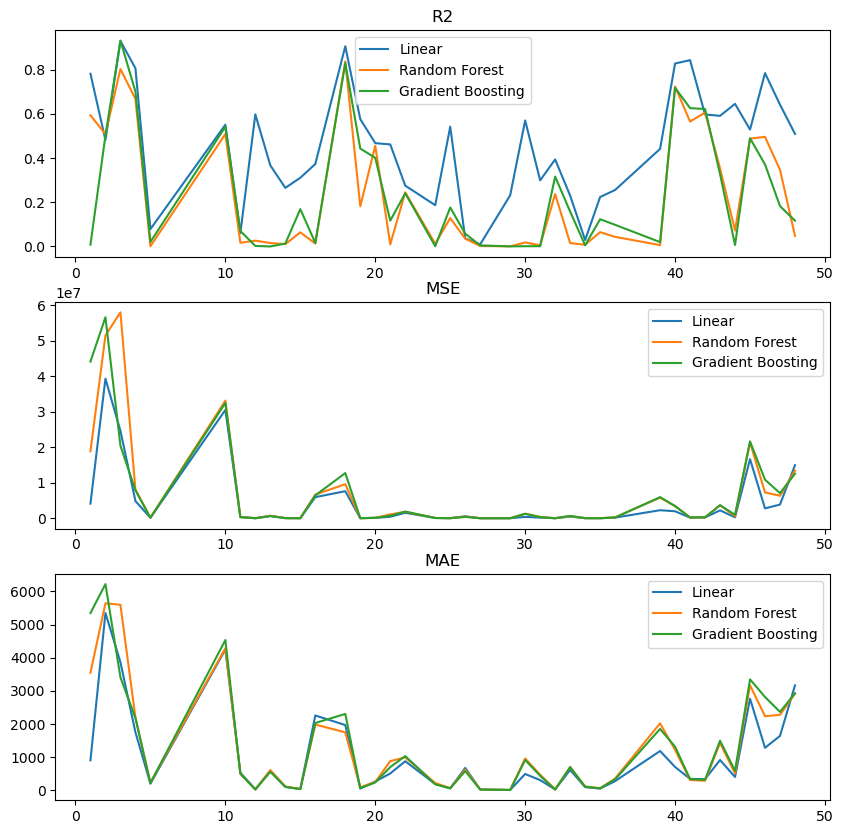

In [37]:
display_mesure(data2, [Model2.evaluation_model, Model3.evaluation_model, Model4.evaluation_model], ["Linear", "Random Forest", "Gradient Boosting"]);

## Test cross val

In [42]:
from sklearn.model_selection import cross_val_score

Model_cross_val = Model(data, ["forecasted_consumption", "CAC", "STOXX", "BFX", "AEX", "gasNat"],["real_consumption"], 0.8, True, "gradient_boosting")
Model_cross_val.generate_model()
Model_cross_val.generate_train_set()

In [44]:
# Utilise une validation croisée à 5 plis
i = 7
scores = cross_val_score(Model_cross_val.model[i], Model_cross_val.x_train[i], Model_cross_val.y_train[i], cv=5)
# Affiche les performances pour chaque pli
print("Scores:", scores)

/opt/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

Scores: [-0.70449314 -0.55415718  0.39031851  0.81578676  0.39955041]


/opt/miniconda3/envs/data/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
